# Rowing Robot 

In [218]:
import sympy as sm
import sympy.physics.mechanics as me
me.init_vprinting()

# Setting variables

In [219]:
q1, q2, q3 = me.dynamicsymbols('q1:4')
u1, u2, u3 = me.dynamicsymbols('u1:4')
l1, l2, l3 = sm.symbols('l1:4')
m1, m2, m3, g = sm.symbols('m1, m2, m3, g')

T1, T2 = me.dynamicsymbols('T1:3')

In [220]:
N = me.ReferenceFrame('N')
A = N.orientnew('A', 'Axis', (q1, N.z))
B = A.orientnew('B', 'Axis', (q2, -A.z))
C = A.orientnew('C', 'Axis', (q3, -B.z))

In [221]:
P1 = me.Point('P1')
P2 = P1.locatenew('P2', l1*A.x)
P3 = P2.locatenew('P3', l2*B.x)
P4 = P3.locatenew('P4', l3*C.x)

# Constrains

loop: link feet, knee and hip. 

in this case we "glue" the but of the rower to seat. 

In [222]:
loop = P3.pos_from(P1) - l2*N.x
loop

In [223]:
config_con1 = loop.dot(N.y).simplify()


In [ ]:
#config_con2 = loop.dot(N.y).simplify()
#config_con2

In [229]:
qdots = {q.diff(): u for q, u in zip((q1, q2, q3), (u1, u2, u3))}
qdots

# Velocities

In [230]:
A.set_ang_vel(N, u1*N.z)
B.set_ang_vel(A, -u2*A.z)
C.set_ang_vel(B, -u3*B.z)

In [231]:
P1.set_vel(N, 0)
P1.vel(N)

In [291]:
P2.v2pt_theory(P1, N, A)
P3.v2pt_theory(P2, N, B)
P4.v2pt_theory(P3, N, C)

# Motion Constrains

Have the hips fixed to the bench, aka only movement in x-direction.

In [292]:
mot_con = P3.vel(N).dot(C.x).simplify()

In [293]:
t = me.dynamicsymbols._t

In [294]:
config_con1_dot = config_con1.diff(t).subs(qdots)
config_con1_dot

In [236]:
#config_con2_dot = config_con2.diff(t).subs(qdots)
#config_con2_dot

In [295]:
A.ang_acc_in(N)

In [296]:
P2.acc(N)
P3.acc(N)
P4.acc(N)

In [297]:
particle1 = me.Particle('P2', P2, m1)
particle2 = me.Particle('P3', P3, m2)
particle3 = me.Particle('P4', P4, m3)
particles = [particle1, particle2, particle3]

# loads

In [311]:
loads = [(P2, -m1*g*N.y),
         (P3, -m2*g*N.y),
         (P4, -m3*g*N.y),
         (A, T1*N.z),
         (C, T2*N.z)]

In [313]:
kwargs = dict(
    q_ind=(q1, q3,), # independent generalized coordinates
    u_ind=(u1, ), # independent generalized speed
    kd_eqs=[qd - u for qd, u in qdots.items()], # q' = u for all coordinates
    q_dependent=(q2,), # depdendent coordinates from the kinematic loop
    configuration_constraints=[config_con1,  # kinematic loop config constraints
                             ],
    u_dependent=(u2, u3), # dependent generalized speeds
    velocity_constraints=[mot_con,  # nonholonomic constraint
                          config_con1_dot,  # holonomic motion constraints
                        ]
)

kane = me.KanesMethod(N, # inertial reference frame
                     **kwargs)

NonInvertibleMatrixError: Matrix det == 0; not invertible.

In [242]:
fr, frstar = kane.kanes_equations(particles, loads=loads)

In [243]:
import numpy as np
from scipy.optimize import fsolve
from pydy.system import System

In [244]:
sys = System(kane)

In [245]:
l1_val = 0.8
l2_val = 2.0
l3_val = 2.0

sys.constants = {g: 9.81,
                 l1: l1_val,
                 l2: l2_val,
                 l3: l3_val,
                 m1: 1.0,
                 m2: 1.0, 
                 m3: 1.0}

In [246]:
q1_0 = np.deg2rad(45.0)
q3_0 = np.deg2rad(45.0)

In [247]:
eval_config_con = sm.lambdify((q1, q2, l1, l2),
                              sm.Matrix([config_con1]))

In [248]:
eval_config_con_fsolve = lambda x, q1, l1, l2: np.squeeze(eval_config_con(q1, x[0], l1, l2))

In [249]:
q2_0 = fsolve(eval_config_con_fsolve, np.ones(1), args=(q1_0, l1_val, l2_val))[0]

np.rad2deg(q1_0), np.rad2deg(q2_0), np.rad2deg(q3_0),

In [250]:
sys.initial_conditions = {q1: q1_0,
                          q2: q2_0,
                          q3: q3_0,
                          u1: 0.0,
                          u2: 0.0,
                          u2: 0.0,
                         }

In [251]:
duration = 6.0
fps = 60.0
sys.times = np.linspace(0.0, duration, num=int(fps*duration))

In [275]:
def step_pulse(x, t):
    if t < 2.0:
        T = 5.0
    elif 3.0 < t < 5.0:
        T = -5.0
    else:
        T = 0.0
    return np.array([T])

In [276]:
sys.specifieds = {T1: step_pulse, T2: step_pulse}

In [277]:
x = sys.integrate()

In [255]:
import matplotlib.pyplot as plt

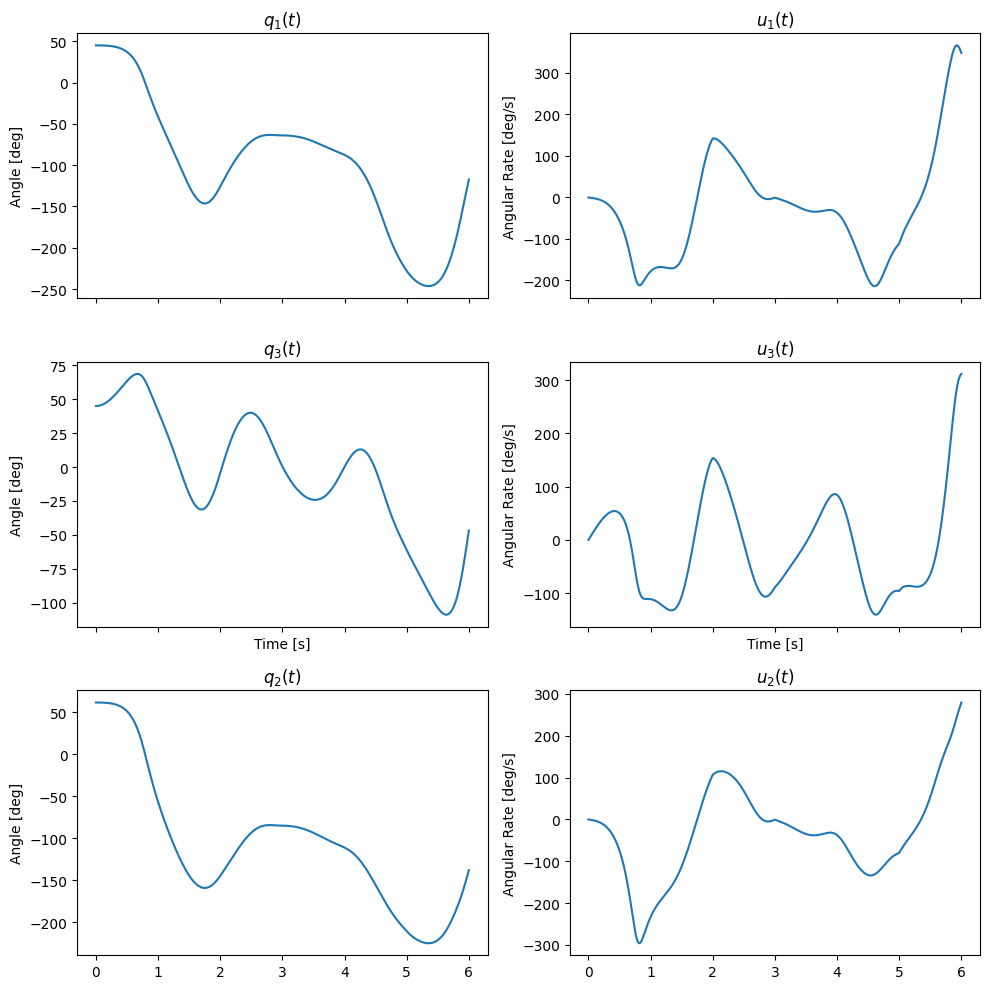

In [278]:
fig, axes = plt.subplots(3, 2, sharex=True)
fig.set_size_inches(10, 10)

for i, (xi, ax, s) in enumerate(zip(x.T, axes.T.flatten(), sys.states)):
    ax.plot(sys.times, np.rad2deg(xi))
    title = sm.latex(s, mode='inline')
    ax.set_title(title)
    if 'q' in title:
        ax.set_ylabel('Angle [deg]')
    else:
        ax.set_ylabel('Angular Rate [deg/s]')

axes[1, 0].set_xlabel('Time [s]')
axes[1, 1].set_xlabel('Time [s]')

plt.tight_layout()

# Animation

In [257]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [258]:
P2.pos_from(P1).express(N).simplify()

In [259]:
P3.pos_from(P2).express(N).simplify()

In [279]:
P4.pos_from(P3).express(N).simplify()

In [280]:
q1_vals = x[:, 0]
q2_vals = x[:, 1]
q3_vals = x[:, 2]

p2_xy = np.array([l1_val*np.cos(q1_vals),
                  l1_val*np.sin(q1_vals)])

p3_xy = p2_xy + np.array([l2_val*np.cos(q1_vals - q2_vals),
                          l2_val*np.sin(q1_vals - q2_vals)])

p4_xy = p3_xy + np.array([l3_val*np.cos(q1_vals + q3_vals),
                          l3_val*np.sin(q1_vals + q3_vals)])



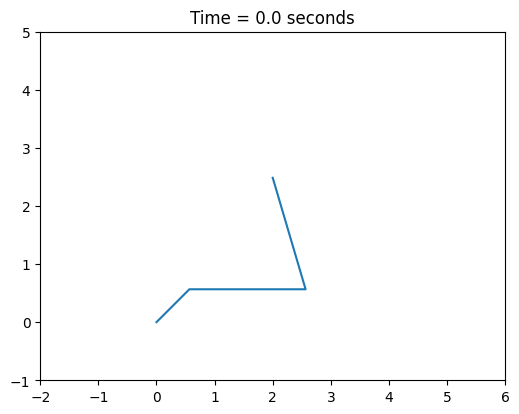

In [281]:
fig, ax = plt.subplots()
fig.set_size_inches((6, 5))
line, = ax.plot([0.0, p2_xy[0, 0], p3_xy[0, 0], p3_xy[0, 0], p4_xy[0, 0]],
                [0.0, p2_xy[1, 0], p3_xy[1, 0], p3_xy[1, 0], p4_xy[1, 0]])
title = 'Time = {:0.1f} seconds'
ax.set_title(title.format(0.0))
ax.set_ylim((-1.0, 5.0))
ax.set_xlim((-2.0, 6.0))
ax.set_aspect('equal')

In [282]:
def update(i):
    xdata = [0.0, p2_xy[0, i], p3_xy[0, i], p3_xy[0, i], p4_xy[0, i]]
    ydata = [0.0, p2_xy[1, i], p3_xy[1, i], p3_xy[1, i], p4_xy[1, i]]
    line.set_data(xdata, ydata)
    ax.set_title(title.format(sys.times[i]))
    return line,

ani = FuncAnimation(fig, update, save_count=len(sys.times))

In [283]:
HTML(ani.to_jshtml(fps=fps))